## This notebook still needs updating.

In [1]:
import os
import numpy as np
from astropy.table import Table, join, Column
import matplotlib.pyplot as plt
from astropy import units as u
import edge_pydb
from edge_pydb import EdgeTable
from edge_pydb.xy2hist import xy2hist
from edge_pydb.conversion import stmass_pc2, msd_co, sfr_ha
np.seterr(divide='ignore', invalid='ignore')

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

## Depletion time vs stellar surface density for EDGE.  

In [2]:
try:
    hatab = EdgeTable('edge.pipe3d.hdf5', path='flux_elines_sm', 
                      cols=['Name','ix','iy','flux_Halpha','flux_Hbeta','e_flux_Halpha'])
    sttab = EdgeTable('edge.pipe3d.hdf5', path='SSP_sm', 
                      cols=['Name','ix','iy','mass_ssp'])
    cotab = EdgeTable('edge.comom_smo7.hdf5', path='smo')
    print('Working on full EDGE database')
except:
    hatab = EdgeTable('NGC4047.pipe3d.hdf5', path='flux_elines_sm', 
                      cols=['Name','ix','iy','flux_Halpha','flux_Hbeta','e_flux_Halpha'])
    sttab = EdgeTable('NGC4047.pipe3d.hdf5', path='SSP_sm', 
                      cols=['Name','ix','iy','mass_ssp'])
    cotab = EdgeTable('NGC4047.comom_smo7.hdf5', path='smo')
    print('Working on NGC 4047 data')

Working on full EDGE database


In [3]:
cotab.join(hatab, keys=['Name','ix','iy'])
cotab.join(sttab, keys=['Name','ix','iy'])

In [4]:
# For stellar surface density we need distance
califa = EdgeTable('edge_califa.csv', cols=['Name','caDistMpc'])
cotab.join(califa)
print(cotab.colnames)

['Name', 'ix', 'iy', 'ra_off', 'dec_off', 'rad_arc', 'azi_ang', 'emom0max', 'mom0', 'emom0', 'flux_Halpha', 'flux_Hbeta', 'e_flux_Halpha', 'mass_ssp', 'caDistMpc']


In [5]:
# Derived quantities for the CO detections
det = (cotab['mom0']>3*cotab['emom0']) & (cotab['flux_Halpha']>3*cotab['e_flux_Halpha'])

sig_mol = msd_co(cotab['mom0'][det], name='sig_mol')
sig_sfr = sfr_ha(cotab['flux_Halpha'][det],cotab['flux_Hbeta'][det], name='sig_sfr')

t_dep = Column(sig_mol.quantity/sig_sfr.quantity, name='t_dep')
print('Number of CO and Ha detections:',len(t_dep))

sig_star = stmass_pc2(cotab['mass_ssp'][det], 
            dist=cotab['caDistMpc'][det].quantity, name='sig_star')
sig_ssfr = Column(sig_sfr.quantity/sig_star.quantity, name='sig_ssfr')
Table([sig_mol,sig_sfr,t_dep,sig_star,sig_ssfr]).pprint(max_width=100)

Number of CO and Ha detections: 4805
   sig_mol          sig_sfr             t_dep             sig_star            sig_ssfr      
solMass / pc2 solMass / (Gyr pc2)        Gyr           solMass / pc2          1 / Gyr       
------------- ------------------- ------------------ ------------------ --------------------
    20.621445                 nan                nan  36.71501810860789                  nan
    41.519775                 nan                nan 43.736734679675244                  nan
     32.75522   19.58841404141607 1.6721730731545974  53.71304200581526   0.3646863649855341
    16.468155   2.725863840258723  6.041444427269523  44.35584190879939 0.061454449356713965
    26.164415   29.37603630149374 0.8906720801596585  23.21323206313237   1.2654866940372873
      22.4153   4.212032961495991  5.321729571959816 43.151987306943084  0.09760924639543268
    10.568909                 nan                nan  26.75223953855134                  nan
    23.705904                 nan

In [6]:
# Derived quantities for the CO non-detections
ndet = (cotab['flux_Halpha']>3*cotab['e_flux_Halpha']) & ~det

h2_ndet = msd_co(3*cotab['emom0max'][ndet], name='sig_mol_ul')
sf_ndet = sfr_ha(cotab['flux_Halpha'][ndet],cotab['flux_Hbeta'][ndet], name='sig_sfr_ul')

t_dep_ndet = Column(h2_ndet.quantity/sf_ndet.quantity, name='t_dep_ul')
print('Number of CO non-detections, Ha detections:',len(t_dep_ndet))

sig_star_ndet= stmass_pc2(cotab['mass_ssp'][ndet], 
            dist=cotab['caDistMpc'][ndet].quantity, name='sig_star_ul')
sig_ssfr_ndet = Column(sf_ndet.quantity/sig_star_ndet.quantity, name='sig_ssfr_ul')
Table([h2_ndet,sf_ndet,t_dep_ndet,sig_star_ndet,sig_ssfr_ndet]).pprint(max_width=100)

Number of CO non-detections, Ha detections: 30638
  sig_mol_ul       sig_sfr_ul          t_dep_ul         sig_star_ul         sig_ssfr_ul     
solMass / pc2 solMass / (Gyr pc2)        Gyr           solMass / pc2          1 / Gyr       
------------- ------------------- ------------------ ------------------ --------------------
    15.878894  0.2769573027201647  57.33336401054492 10.334477338323122 0.026799352657451758
    15.605012  0.5282567450530545 29.540582465132896 10.334477338323122  0.05111596143272106
    15.412052   2.546656173792734  6.051877875444745  43.63902602491492  0.05835731009071482
    15.293785  2.9042200290569924  5.266055926272492  41.03653982265107  0.07077156216406776
    15.250212  1.2956651843795366 11.770179441073125  41.03653982265107  0.03157345112378028
    15.281335  0.8182700386782484 18.675173420376115  65.73574470159393 0.012447870521476079
    15.380929  1.5843728789142277  9.707897173653757  68.28711449428235 0.023201637536564627
    15.561442       

## Depletion time vs. local stellar density

Excluding 10 invalid values
Number of valid points: 4795


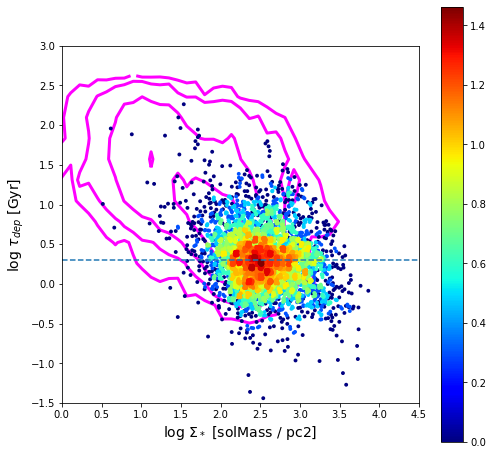

In [7]:
# Select data to plot (must be loggable)
not_nan = (~np.isnan(sig_star)) & (~np.isnan(t_dep)) & (sig_star>0) & (t_dep>0)
not_nan_ndet = (~np.isnan(sig_star_ndet)) & (~np.isnan(t_dep_ndet)) & (sig_star_ndet>0) & (t_dep_ndet>0)
print('Excluding {} invalid values'.format(len(np.nonzero(~not_nan)[0])))
print('Number of valid points:',len(np.nonzero(not_nan)[0]))

x_det, y_det, z_det, *hist = xy2hist(sig_star[not_nan], t_dep[not_nan], log=True)
x_ndet, y_ndet, z_ndet, *hist2 = xy2hist(sig_star_ndet[not_nan_ndet], 
                                         t_dep_ndet[not_nan_ndet], 
                                         log=True, bins=[50,50])
# Make the scatter plots
fig, ax = plt.subplots(figsize=(8,8))
cm = plt.cm.get_cmap('jet')
sc = ax.scatter(x_det, y_det, c=z_det, s=15, edgecolor='', cmap=cm)
ax.contour(hist2[0].transpose(),[10,30,100,300],
           extent=[hist2[1].min(),hist2[1].max(),
                   hist2[2].min(),hist2[2].max()],
           colors='magenta',linewidths=3,zorder=-1)
plt.xlabel(r'log $\Sigma_*$ ['+str(sig_star.unit)+']',fontsize=14)
plt.ylabel(r'log $\tau_{dep}$ ['+str(t_dep.unit)+']',fontsize=14)
ax.set_aspect('equal')
ax.axhline(0.3, linestyle='--')
ax.set_xlim(0,4.5)
ax.set_ylim(-1.5,3)
plt.colorbar(sc)

## Depletion time vs. local sSFR

Excluding 10 invalid values
Number of valid points: 4795


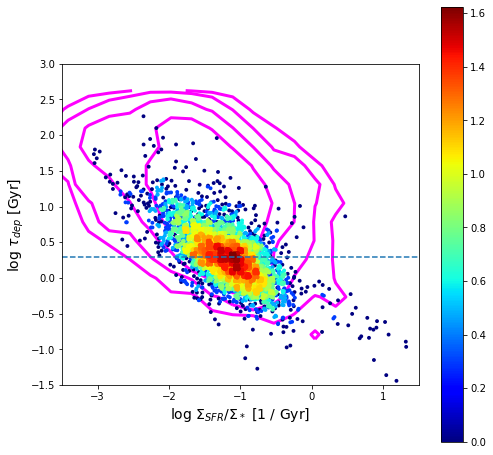

In [8]:
# Select data to plot (must be loggable)
not_nan = (np.isfinite(sig_ssfr)) & (np.isfinite(t_dep)) & (sig_ssfr>0) & (t_dep>0)
not_nan_ndet = (np.isfinite(sig_ssfr_ndet)) & (np.isfinite(t_dep_ndet)) & (sig_ssfr_ndet>0) & (t_dep_ndet>0)
print('Excluding {} invalid values'.format(len(np.nonzero(~not_nan)[0])))
print('Number of valid points:',len(np.nonzero(not_nan)[0]))

x_det, y_det, z_det, *hist = xy2hist(sig_ssfr[not_nan], t_dep[not_nan], log=True)
x_ndet, y_ndet, z_ndet, *hist2 = xy2hist(sig_ssfr_ndet[not_nan_ndet], 
                                         t_dep_ndet[not_nan_ndet], 
                                         log=True, bins=[50,50])
# Make the scatter plots
fig, ax = plt.subplots(figsize=(8,8))
cm = plt.cm.get_cmap('jet')
sc = ax.scatter(x_det, y_det, c=z_det, s=15, edgecolor='', cmap=cm)
ax.contour(hist2[0].transpose(),[10,30,100,300],
           extent=[hist2[1].min(),hist2[1].max(),
                   hist2[2].min(),hist2[2].max()],
           colors='magenta',linewidths=3,zorder=-1)
plt.xlabel(r'log $\Sigma_{SFR}$/$\Sigma_*$ ['+str(sig_ssfr.unit)+']',fontsize=14)
plt.ylabel(r'log $\tau_{dep}$ ['+str(t_dep.unit)+']',fontsize=14)
ax.set_aspect('equal')
ax.axhline(0.3, linestyle='--')
ax.set_xlim(-3.5,1.5)
ax.set_ylim(-1.5,3)
plt.colorbar(sc)